In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification # used for constant model changes
# needed for class labels 0-9 else res-50 gives error
from datasets import load_dataset, concatenate_datasets, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image

#!rm -rf /content/directory # in case to delete files

In [2]:
# load dataset
ds = load_dataset("EnmmmmOvO/insect-pest-dataset")

train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds  = ds["test"]

# KRandom sample to shrink dataset
train_ds = train_ds.shuffle(seed=42).select(range(15000))  # 15k images instead of 45k
val_ds  = val_ds.shuffle(seed=42).select(range(4000))
test_ds  = test_ds.shuffle(seed=42).select(range(4500))

print(train_ds)
print(val_ds)
print(test_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/596 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/552M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45095 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22619 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7508 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 15000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 4500
})


In [3]:
# Create class labels as original data doesn't have them explicitly in images
num_classes = len(set(train_ds["label"]))
train_ds = train_ds.cast_column("label", ClassLabel(num_classes=num_classes))
val_ds = val_ds.cast_column("label", ClassLabel(num_classes=num_classes))
test_ds = test_ds.cast_column("label", ClassLabel(num_classes=num_classes))
print(num_classes)

Casting the dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4500 [00:00<?, ? examples/s]

102


In [4]:
processor = AutoImageProcessor.from_pretrained("google/efficientnet-b1", size={"height": 128, "width": 128})
model = AutoModelForImageClassification.from_pretrained("google/efficientnet-b1",num_labels=num_classes, ignore_mismatched_sizes=True) # auto as model changes common

# Training augmentation
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# Validation / Test (no augmentation)
val_transform = transforms.Resize((128,128))

def transform(batch, train=True):
    pixel_values = []
    for img in batch["image"]:
        # Convert to PIL Image for easier actions
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))

        # Convert grayscale or RGBA to RGB
        img = img.convert("RGB")

        # Apply augmentations / resize
        if train:
            img = train_transform(img)
        else:
            img = val_transform(img)

        # Convert to tensor
        pv = processor(img, return_tensors="pt")["pixel_values"].squeeze(0) # squeeze for better data
        pixel_values.append(pv)
    batch["pixel_values"] = pixel_values
    return batch


train_ds = train_ds.with_transform(lambda b: transform(b, train=True))
val_ds   = val_ds.with_transform(lambda b: transform(b, train=False))
test_ds  = test_ds.with_transform(lambda b: transform(b, train=False))



# use collator for image sets
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return pixel_values, labels

# data loaders
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/31.6M [00:00<?, ?B/s]

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b1 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([102, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4) #, weight_decay=1e-4

# Lists for plotting
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epochs = 40 # cahnged as 50 was too much for computer to handle

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for pixel_values, labels in train_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total

    # Save results for plotting
    train_loss_list.append(avg_loss)
    train_acc_list.append(accuracy)



    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for pixel_values, labels in val_loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    # Save validation results
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)


    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy*100:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")

Using device: cuda

Epoch 1/40
Train Loss: 2.9814, Train Accuracy: 31.65%
Val Loss: 2.2880, Val Accuracy: 43.10%

Epoch 2/40
Train Loss: 1.9176, Train Accuracy: 50.11%
Val Loss: 2.0268, Val Accuracy: 48.18%

Epoch 3/40
Train Loss: 1.4613, Train Accuracy: 60.37%
Val Loss: 1.9029, Val Accuracy: 51.88%

Epoch 4/40
Train Loss: 1.1384, Train Accuracy: 67.70%
Val Loss: 1.9148, Val Accuracy: 52.92%

Epoch 5/40
Train Loss: 0.8844, Train Accuracy: 74.38%
Val Loss: 1.9964, Val Accuracy: 52.15%

Epoch 6/40
Train Loss: 0.6929, Train Accuracy: 79.37%
Val Loss: 2.0436, Val Accuracy: 52.48%

Epoch 7/40
Train Loss: 0.5617, Train Accuracy: 83.10%
Val Loss: 2.1930, Val Accuracy: 52.42%

Epoch 8/40
Train Loss: 0.4604, Train Accuracy: 86.15%
Val Loss: 2.1727, Val Accuracy: 53.73%

Epoch 9/40
Train Loss: 0.3941, Train Accuracy: 87.93%
Val Loss: 2.2870, Val Accuracy: 52.70%

Epoch 10/40
Train Loss: 0.3505, Train Accuracy: 89.38%
Val Loss: 2.5203, Val Accuracy: 52.83%

Epoch 11/40
Train Loss: 0.3141, Train A

In [9]:
model.eval()
correct = 0
total = 0
running_loss = 0.0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():  # no gradients needed
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)
        running_loss += loss.item()

        # get predictions
        #preds = torch.max(pred_class, 1)
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_loss = running_loss / len(test_loader)
accuracy = correct / total

print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.4f}")

Test Loss: 3.2532 | Test Accuracy: 0.5098


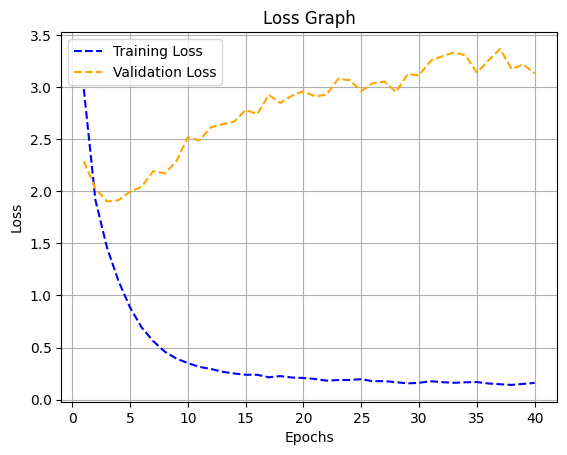

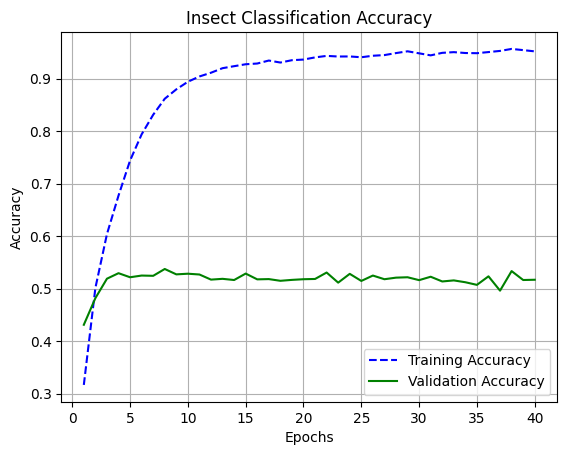

In [10]:
epoch_plt = range(1, epochs + 1)

# Loss plot
plt.plot(epoch_plt, train_loss_list, label='Training Loss', linestyle='--', color='blue')
plt.plot(epoch_plt, val_loss_list, label='Validation Loss', linestyle='--', color='orange')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot
plt.plot(epoch_plt, train_acc_list, label='Training Accuracy', linestyle='--', color='blue')
plt.plot(epoch_plt, val_acc_list, label='Validation Accuracy', color='green')
plt.title('Insect Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


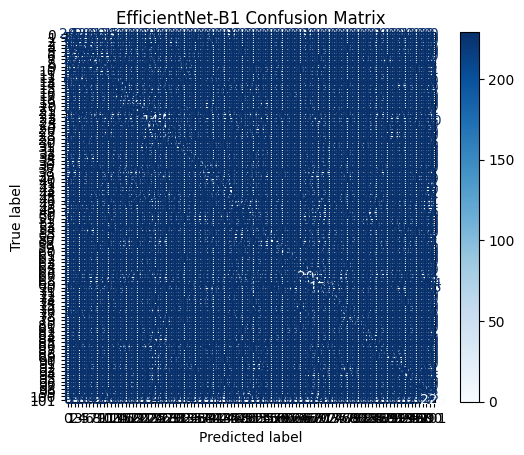

In [11]:
# ---- CONFUSION MATRIX ----
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, data_loader, device):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for pixel_values, labels in data_loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=pixel_values)
            preds = outputs.logits.argmax(dim=1)

            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
    return np.array(all_true), np.array(all_pred)

# Get predictions on validation or test set
true_labels, pred_labels = get_predictions(model, val_loader, device)
# Class names
class_names = train_ds.features["label"].names
# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("EfficientNet-B1 Confusion Matrix")
plt.show()


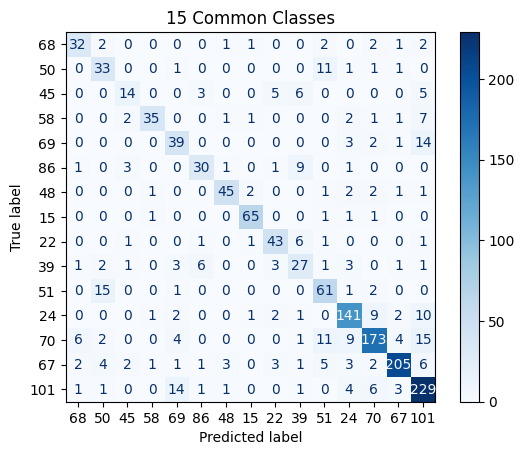

In [12]:
# Limited Matrix
k = 15   # top 10 classes

# Find the k most common true labels
unique, counts = np.unique(true_labels, return_counts=True)
top_k_classes = unique[np.argsort(counts)[-k:]]

# Filter labels to only include those classes
mask = np.isin(true_labels, top_k_classes)
filtered_true = true_labels[mask] # limit classes
filtered_pred = pred_labels[mask]

filtered_cm = confusion_matrix(filtered_true, filtered_pred, labels=top_k_classes)

filtered_names = [class_names[i] for i in top_k_classes]

disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=filtered_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("15 Common Classes")
plt.show()


In [16]:
# Print accuracy, precision,recall, f1-score
acc = accuracy_score(true_labels, pred_labels)
prec  = precision_score(true_labels, pred_labels, average='macro', zero_division=0) # macro used to deal with inbalanced
recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
f1_sc     = f1_score(true_labels, pred_labels, average='macro', zero_division=0)

print("Classification (With Macro)")
print("")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1_sc:.4f}")

Classification (With Macro)

Accuracy:  0.5168
Precision: 0.4471
Recall:    0.4426
F1-Score:  0.4295
